### NEW

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import accumulate
import json

def plot_seaborn2(
        model_paths, aes=None, 
        palette="bright", title=None, x="time", y_ax="MSE Loss", xlim=None, ylim=None, xmin=None, ymin=None, 
        aes1="Arch", aes2="Layers",
        vbars=[], hide_legend=False, cutoff=None):
    
    sns.set_theme(
        palette=palette,
        style="whitegrid",
    )

    # Data collection for plotting
    plot_data = []

    for i, m in enumerate(model_paths):
        with open(f'saved/{m[1]}.json', 'r') as file:
            model_data = json.load(file)

        values = np.array(model_data[m[2]])

        if m[3] == "avg":
            plot_losses = np.mean(values, axis=0)
        elif m[3] == "med":
            plot_losses = np.median(values, axis=0)
        elif m[3] == "best":
            plot_losses = np.min(values, axis=0)

        if(cutoff != None):
            plot_losses = plot_losses[:cutoff]

        print(f"Avg over last 5 epochs on {aes[i][0]},{aes[i][1]},{m[3]}: {np.mean(plot_losses[-5])}")
        
        for t, l in zip((range(len(plot_losses))), plot_losses):
            plot_data.append({
                "Time" if x == "time" else "Epoch": t,
                y_ax: l,
                aes1: aes[i][0],
                aes2: aes[i][1],
            })

    # Convert to DataFrame
    df = pd.DataFrame(plot_data)

    # Plotting with Seaborn
    plt.figure(figsize=(10, 6))
    x_col = "Time" if x == "time" else "Epoch"

    ax = sns.lineplot(data=df, x=x_col, y=y_ax, hue=aes1, style=aes2, markers=False)

    if title:
        ax.set_title(title, fontsize=14, pad=15)
    
    ax.set_xlabel("Time (s)" if x == "time" else "Epochs", labelpad=10)
    ax.set_ylabel(y_ax, labelpad=10)

    if ylim is not None:
        ax.set_ylim(ymin if ymin is not None else 0, ylim)
    if xlim is not None:
        ax.set_xlim(xmin if xmin is not None else 0, xlim)

    # Add vertical bars
    for (loc, col) in vbars:
        plt.axvline(x=loc, color=col, linestyle="--")

    # Hide legend if needed
    if hide_legend:
        ax.legend_.remove()

    # Display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
import importlib, utils
importlib.reload(utils)

selector = "med"
data = "vals"

plot_seaborn2(
    model_paths=[
        
        # ("", "", "", ""),
        # ("", "zeroed_[4]", "losses", "med"),
        # ("", "zeroed_[8]", "losses", "med"),

    ],
    aes=[
        # ("zeroed", "[4]"),
        ("zeroed", "[8]"),
    ],
    x = "epochs",
    ylim = .8,
    ymin = .2,
)

In [ ]:
import json, torch

file = ""
with open(f'saved/{file}.json', 'r') as file:
    model_data = json.load(file)

print(torch.mean(model_data["zeroed_counter"][1]))

In [11]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X, y = housing.data, housing.target
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [24]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

bikes = pd.read_csv('bikesharing/day.csv') # not spatial
filtered = bikes.copy()
remove = ["dteday", "yr", "instant", "casual", "registered", "season", "workingday"]
for column in remove:
    filtered = filtered.drop(column, axis=1)

data = filtered.drop("cnt", axis=1)
target = filtered["cnt"]
X, y = data.values, target.values

import numpy as np

# Compute standard deviation
std = np.std(y)

print("Standard Deviation:", std)
print("Range:", np.max(y), "to", np.min(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# using a dataloader to randomize batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

print(next(iter(train_loader)))

Standard Deviation: 1935.8859561152221
Range: 8714 to 22
[tensor([[10.0000,  0.0000,  0.0000,  2.0000,  0.4158,  0.4198,  0.7083,  0.1412]]), tensor([[3510.]])]


In [ ]:
import utils, importlib
importlib.reload(utils)

locs,coeffs = utils.train_models_count_zeroed_AFs(
    runs = 1,
    layers=[8], 
    epochs={"relu": 150, "both": 0, "bspline": 10}
)

layer_to_plot = 0
utils.plot_bsplines(locs[layer_to_plot], coeffs[layer_to_plot], 4)

In [ ]:
import regression7
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import torch
import importlib

importlib.reload(regression7)

import sys, os
sys.path.insert(0, os.path.abspath('../DeepSplines'))
import deepsplines

torch.set_num_threads(1)

# Load the data
housing = fetch_california_housing()
X, y = housing.data, housing.target

run_summaries = []
run_validations = [] # validations
run_history = [] # training 
run_epoch_times = []
outliers = 0

# comp relu
cr_run_summaries = []
cr_run_validations = [] # validations
cr_run_history = [] # training 
cr_run_epoch_times = []

mparams = regression7.Config(
    layers = [8],
    cpoints = 3,
    range_ = 1,
)
        
tparams = regression7.Config(
    epoch_specs = ["150R", "10B", "50FB", "10B", "50FB", "10B", "50FB", "50L"],
    comp_relu = 0,

    batch_size = 10,
    lr_wb = 0.001,
    lr_bs = 0.0001,
    lr_ls = 0.0001,
    lrs = "none",
    lrs_gamma = .9,
    lrs_stepsize = 5,
)

model, train_history, val_history, train_times, cr_val_history, cr_train_history, cr_train_times = regression7.training_run(mparams, tparams, X, y)

run_validations.append(val_history)
run_history.append(train_history)
run_epoch_times.append(train_times) # microsec to seconds

cr_run_validations.append(cr_val_history)
cr_run_history.append(cr_train_history)
cr_run_epoch_times.append(cr_train_times) # microsec to seconds

data = {
    "mparams": mparams.to_dict(),
    "tparams": tparams.to_dict(),
    "times": run_epoch_times,
    "vals": run_validations,
    "trains": run_history,
    "cr_times": cr_run_epoch_times,
    "cr_vals": cr_run_validations,
    "cr_trains": cr_run_history,
}

import json
with open(f'saved/this mah test.json', 'w') as f:
        json.dump(data, f)

### OLD

In [ ]:
from regression7 import training_run, Config
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from models import LinearBSpline

import torch
import utils
import importlib
importlib.reload(utils)

mparams = Config(
    layers = [8],
    cpoints = 3,
    range_ = 1,
)
        
tparams = Config(
    epoch_specs = ["150R", "10B"],
    comp_relu = 0,

    batch_size = 10,
    lr_wb = 0.001,
    lr_bs = 0.0001,
    lr_ls = 0.0001,
    lr_fb = 0.0001,
    lr_transfer_WBS = 0.0001,
    lrs = "none",
    lrs_gamma = .9,
    lrs_stepsize = 5,
)

# Load the data
housing = fetch_california_housing()
X, y = housing.data, housing.target

model, train_history, val_history, train_times2, cr_val_history, cr_train_history, cr_train_times2 = training_run(mparams, tparams, X, y)

[tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]])]
[tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])]


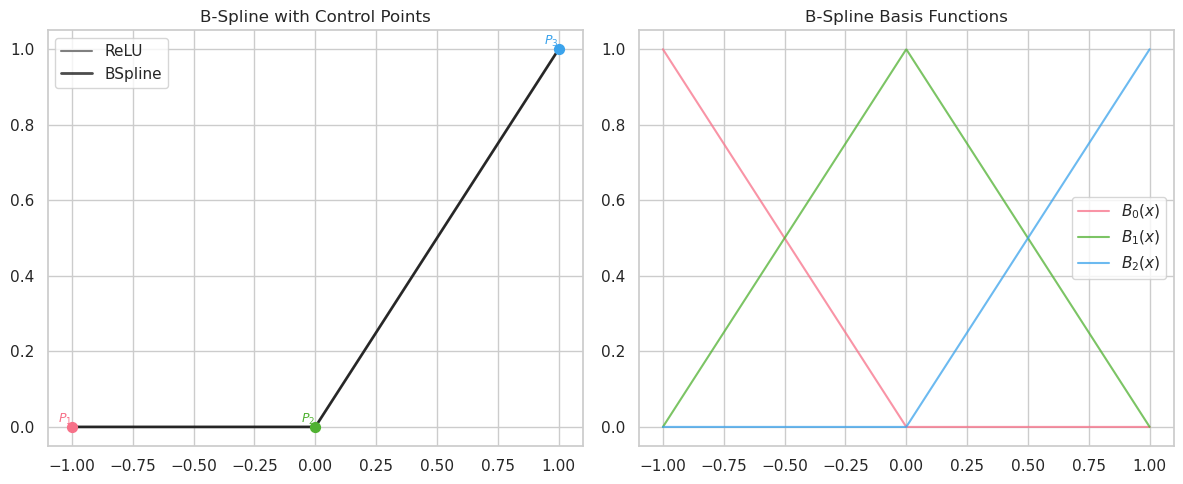

In [12]:
import importlib
import sys, os
sys.path.insert(0, os.path.abspath('../DeepSplines'))
import deepsplines
import utils
importlib.reload(utils)
from models import LinearBSpline


model = LinearBSpline([4], 3, 1)
# print(utils.get_model_zeroed_activations(model))

# layer_locs = []
# layer_coeffs = []

# layer = model.get_layers()[1]
# coeffs = layer.coefficients_vect.view(layer.num_activations, layer.size).detach()
# layer_locs.append(layer.grid_tensor.detach())
# layer_coeffs.append(coeffs)
# layer_to_plot = 0
# utils.plot_bsplines(layer_locs[layer_to_plot], layer_coeffs[layer_to_plot], 1)

layer_locs = []
layer_coeffs = []

for layer in range(len(model.get_deepspline_activations())):
    layer_locs.append(model.get_deepspline_activations()[layer]['locations'])
    layer_coeffs.append(model.get_deepspline_activations()[layer]['coefficients'])

print(layer_locs)
print(layer_coeffs)

layer = 0
sel = 0
# print(layer_locs[layer][sel])
# print(layer_coeffs[layer][sel])

utils.plot_bspline_sb_side_by_side(layer_locs[layer][sel], layer_coeffs[layer][sel])


[tensor([[-1.,  0.,  1.]])]
[tensor([[0., 0., 1.]])]


IndexError: index 3 is out of bounds for dimension 0 with size 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = final_locs[sel]
y = final_coeffs[sel]

x_new = np.linspace(x.min(), x.max(), 100)

y_new = np.interp(x_new, x, y)
plt.scatter(x, y, color='red', label='Original Data')
plt.plot(x_new, y_new, color='blue', label='Interpolated Curve')

plt.title('Piecewise Linear Interpolation with numpy.interp')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from datetime import datetime
from sklearn.datasets import fetch_california_housing
from regression7 import Config, training_run


# Load the data
housing = fetch_california_housing()
X, y = housing.data, housing.target

mparams = Config(
    layers = [8],
    cpoints = 3,
    range_ = 1,
)
        
tparams = Config(
    relu_epochs = 200,
    bspline_epochs = 50,
    both_epochs = 0,
    lspline_epochs = 0,
    
    batch_size = 10,
    lr_wb = 0.001,
    lr_bs = 0.0001,
    lr_ls = 0.0001,
    lrs = "none",
    lrs_gamma = .9,
    lrs_stepsize = 5,
    comp_relu = 0,
    bspline_order = ["bspline", "both"],
)

print("Init complete.")

start_time = datetime.now()
model, train_history, val_history, train_times, cr_val_history, cr_train_history, cr_train_times = training_run(mparams, tparams, X, y)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import accumulate
import numpy as np

sns.set_theme(style="whitegrid", palette="bright")

plot_data = []

values = np.array(val_history)

x = "epochs"

for idx, l in enumerate(values):
    plot_data.append({
        "Epoch": idx,
        "MSE Loss": l,
    })

# Convert to DataFrame
df = pd.DataFrame(plot_data)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))

ax = sns.lineplot(data=df, x="Epoch", y="MSE Loss", markers=False)
ax.set_xlabel("Epochs", labelpad=10)
ax.set_ylabel("MSE Loss", labelpad=10)

ax.set_ylim(.3, 1)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
print(model.get_layers())

In [15]:
import json

path = "RB"
# model = "[8]_(0.001,0.0001,0.0001)_(['150R', '10B'])_100"
# model = "[24, 8]_(0.001,0.0001,0.0001)_(['150R', '10B'])_100"
model = "[24, 48, 24, 8]_(0.001,0.0001,0.0001)_(['150R', '10B'])_100"

with open(f'saved/{path}/{model}.json', 'r') as file:
    model_data = json.load(file)

    sums = [0] * len(model_data["zeroed"][0])
    for run in model_data["zeroed"]:
        for l_idx,l_val in enumerate(run):
            sums[l_idx] += l_val
    
    num_runs = len(model_data["zeroed"])
    print([x / num_runs for x in sums])


[4.06, 10.4, 8.47, 2.11]
